In [1]:
"""
Data Exploration Notebook
"""

'\nData Exploration Notebook\n'

In [120]:
import math

import helper
from analyzer import Analyzer, group_tweets_by_calendar_week
from crawler import Crawler
from plotter import Plotter
# from model import Vader, TrainedSentimentModel, TextBlob

# Extra imports
import datetime
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import statistics as stat

In [3]:
SCAN_ID = "all"

config_dict = {
	"user_auth": False,  # autheticate as user or application
	"search": {
		"location": "darmstadt",  # based on helper.GEOCODES dictionary
		"radius": 100,  # optional default to 100
		"query": ['der, die, das'],  # query for searching (str array), either query or location has to be not empty
		"max_searches": 5000,  # Default: 1000 max amount of searches
		"num_results": 5000,  # number of results with defined filter options
		"rate_limit": True,  # Default True: to turn off rate limit prints
		"filter": {  # Filter applies to search
			"not_reply": True,  # Filters for not replies when true, does nothing when false
			"not_retweet": True,  # Filters for not retweets when true, does nothing when false
			"until": datetime.datetime(2020, 3, 1),  # None or datetime (e.g. datetime.datetime(2020, 5, 20))
		}
	},
	"get_user": {  # Optional, only when querying for users
		"good_user": True,  # mandatory
		"search_type": "recent_user",  # 'recent_user', 'recent_retweeted_user'
		"num_users": 30,  # mandatory
		"unique_ids": True,  # If true will remember user ids in session
	},
	"analyze_sentiment": {
		"pos_boundary": 0.8,  # boundary for classifying tweets as "extremely" positive
		"neg_boundary": 0.7,  # boundary for classifying tweets as "extremely" negative
		"users_dir": "saved_data/full_scan_both/results/all/".format(SCAN_ID)  # there the sentiment analysis files are stored
	},
	"plot": {
		"title": "Testing",
		"group_by": 1,  # number of days of each group in the histogramm
		"end_date": datetime.datetime(2020, 3, 31, 23, 59),  # last day included in the analysis
		"start_date": datetime.datetime(2020, 3, 1)  # first day included in the analysis
	},
	# Full search not tested and should only be used with caution!
	"full_search": {
		"query": "#Corona lang:de",  # the query used for full search
		"env_name": "dev",  # your premium environment name
		"fromDate": "2020" + "01" + "15" + "1200",  # Format: YYYYMMDDHHmm
		"toDate": "2020" + "06" + "01" + "1200"
	},
	# A full scan over 3 areas each hour, should run continuous
	"full_scan": {
		"active": True,
		"path": "saved_data/full_scan/",
		"locations": ["scan_1", "scan_2", "scan_3"],  # All locations used by the scan
	}
}

In [4]:
config = helper.init_config(config_dict)
crawler = Crawler(config)

In [8]:
def get_reduced_tweets(scan_id: int=None, begin_id: int=None, end_id: int=None):
    """
    :param scan_id: Defines the specific id to folder, if None, will take all folders into the output
    """
    analysation_dicts = []
    if scan_id is None:
        all_user_ids = set()
        user_filenames = []
        for i in range(0, 3):
            users_dir = "saved_data/full_scan_both/tweets/{}/".format(i)
            current_user_ids = [user_id for user_id in sorted(os.listdir(users_dir)) if not user_id in all_user_ids]
            all_user_ids.update(current_user_ids)
            # should all be files, just to be extra sure
            current_user_filenames = [users_dir + filename for filename in current_user_ids if
                                      os.path.isfile(users_dir + filename)]
            user_filenames += current_user_filenames
    else:
        assert scan_id in [0,1,2]
        users_dir = "saved_data/full_scan_both/tweets/{}/".format(scan_id)
        user_filenames = [users_dir + filename for filename in sorted(os.listdir(users_dir)) if
                          os.path.isfile(users_dir + filename)]
    
    # If begin/end_id is None, will go to start from 0/until the end
    user_filenames = user_filenames[begin_id: end_id]
    user_tweets = [crawler.load_tweet_for_analysation(filename) for filename in user_filenames]
    return user_tweets

In [9]:
user_tweets = get_reduced_tweets()

In [12]:
# user_tweets -> List of users, per user a list of ReducedStatus, per ReducedStatus, user_id, text, created_at
print(type(user_tweets[0]))
print(len(user_tweets[0]))

<class 'list'>
597


In [132]:
def hist_analysis(values, bins=50, title="", time=False, **args):
    # Pass additional args for hist via **args
    plt.hist(values, bins=bins, label='#', zorder=1, **args)
    plt.title(title)
    plt.axvline(stat.median(values), label='Median', linestyle='--', color="r", zorder=3)
    plt.axvline(stat.mean(values), label='Mean', linestyle='--', color="#103000", zorder=4)
    if time:
        # Set x labels as hours in the day
        plt.xticks(np.arange(12)*120, [str(x*2) for x in np.arange(12)])
    plt.legend()
    plt.show()
    print("Amount Values: ",  len(values))
    print("Mean: ", stat.mean(values))
    print("Median: ", stat.median(values))
    print("Highest: ", max(values))
    print("Lowest: ", min(values))

Number of Tweets: 1809681


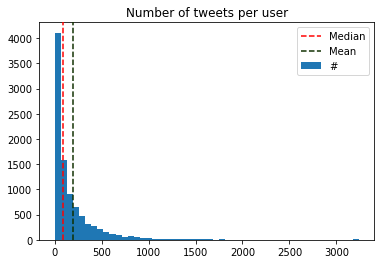

Amount Values:  9384
Mean:  192.8475063938619
Median:  84.5
Highest:  3241
Lowest:  0


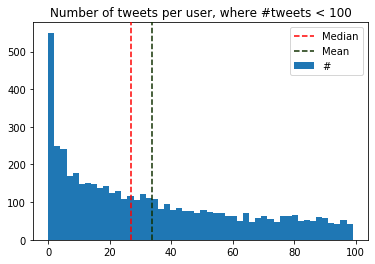

Amount Values:  5065
Mean:  33.58420533070089
Median:  27
Highest:  99
Lowest:  0


In [139]:
# Number of tweets per user Analysis
num_tweets_per_user = [len(timeline) for timeline in user_tweets]
print("Number of Tweets:", sum(num_tweets_per_user))
hist_analysis(num_tweets_per_user, title="Number of tweets per user")

num_tweets_sub_100 = [number for number in num_tweets_per_user if number < 100]
hist_analysis(num_tweets_sub_100, title="Number of tweets per user, where #tweets < 100")

# I think there was a problem-ish in the code for checking:
# In good user: if len(days_until) > 0 and days_until[0] > 7: return False
# Would not return false if len(days_until) == 0, so I think this is why users without tweet actions came through...

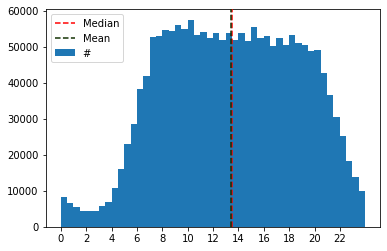

Amount Values:  1809681
Mean:  806.9817929237253
Median:  808
Highest:  1439
Lowest:  0


In [140]:
# Time analysis:
min_passed_all_users = []
for cur_user in user_tweets:
    # Distribution over minutes after 00:00
    min_passed_all_users += [tweet.created_at.hour * 60 + tweet.created_at.minute for tweet in cur_user]

hist_analysis(min_passed_all_users, bins=48, time=True)

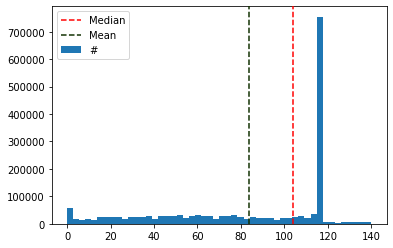

Amount Values:  1809681
Mean:  83.64268177651199
Median:  104
Highest:  140
Lowest:  0


In [178]:
# Twitters max char lenght is 140, but will be cut to 117 if tweet is too long. So can be values between 140 and 117.
# Lowest 0 -> Video or so ...
# Tweets above lenght 140 are chars that are saved weird, e.g. &gt; is > or &lt; is <
# veeeery manual preprocessing, to replace <, >, &
text_lenghts = []
for user in user_tweets:
    lenghts = [len(tweet.text.split("https")[0].replace("&gt;", ">").replace("&lt;", "<").replace("&amp;", "&")) for tweet in user]
    for idx, ln in enumerate(lenghts):
        if ln > 140:
            print(ln, user[idx].text.split("https")[0])
    text_lenghts += lenghts
hist_analysis(text_lenghts, bins=50)